In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/workspace/Code/tutorials/pathology/hovernet/transforms")
sys.path.append('/workspace/Code/tutorials/pathology/hovernet/net')
from net import HoVerNet
from transforms import (
    GenerateWatershedMaskd,
    GenerateInstanceBorderd,
    GenerateDistanceMapd,
    GenerateWatershedMarkersd,
    Watershedd,
)
import joblib
import os
import time
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd
from monai.data import DataLoader, decollate_batch, Dataset, CacheDataset
from monai.metrics import DiceMetric
# from monai.networks.nets import HoVerNet
from monai.utils.enums import HoVerNetBranch
from monai.utils import convert_to_tensor
from monai.transforms import (
    Activations,
    AsDiscrete,
    AsDiscreted,
    Compose,
    ScaleIntensityRanged,
    CastToTyped,
    Lambdad,
    SplitDimd,
    EnsureChannelFirstd,
    ComputeHoVerMapsd,
    RandFlipd,
    RandRotate90d,
    RandGaussianSmoothd,
    FillHoles,
    BoundingRect,
    CenterSpatialCropd,
    GaussianSmooth,
)
import matplotlib.pyplot as plt
    
from monai.apps.pathology.transforms.post import (
    GenerateInstanceContour,
    GenerateInstanceCentroid,
    GenerateInstanceType,
)


def prepare_data(data_dir, fold, splits):
    images = np.load(os.path.join(data_dir, "images.npy"))
    labels = np.load(os.path.join(data_dir, "labels.npy"))

    data = [
        {
            "image": image,
            "image_meta_dict": {"original_channel_dim": -1},
            "label": label,
            "label_meta_dict": {"original_channel_dim": -1},
        }
        for image, label in zip(images, labels)
    ]
    train_data = [data[i] for i in splits[fold]['train']]
    valid_data = [data[i] for i in splits[fold]['valid']]
    
    return train_data, valid_data

def post_process(output, device, return_binary=True, return_centroids=True, output_classes=7):
    post_trans_seg = Compose([
        GenerateWatershedMaskd(keys=HoVerNetBranch.NP.value, softmax=True),
        GenerateInstanceBorderd(keys='mask', hover_map_key=HoVerNetBranch.HV, kernel_size=21),
        GenerateDistanceMapd(keys='mask', border_key='border', smooth_fn=GaussianSmooth()),
        GenerateWatershedMarkersd(keys='mask', border_key='border', threshold=0.99, radius=3, postprocess_fn=FillHoles(connectivity=2)),
        Watershedd(keys='dist', mask_key='mask', markers_key='markers')
    ])
    if HoVerNetBranch.NC.value in output.keys():
        type_pred = Activations(softmax=True)(output[HoVerNetBranch.NC.value])
        type_pred = AsDiscrete(argmax=True)(type_pred)

    pred_inst_dict = post_trans_seg(output)
    pred_inst = pred_inst_dict['dist']

    inst_id_list = np.unique(pred_inst)[1:]  # exclude background
    
    inst_info_dict = None
    if return_centroids:
        inst_info_dict = {}
        for inst_id in inst_id_list:
            inst_map = pred_inst == inst_id
            inst_bbox = BoundingRect()(inst_map)
            inst_map = inst_map[:, inst_bbox[0][0]: inst_bbox[0][1], inst_bbox[0][2]: inst_bbox[0][3]]
            offset = [inst_bbox[0][2], inst_bbox[0][0]]
            try:
                inst_contour = GenerateInstanceContour()(inst_map.squeeze(), offset)
            except:
                print('!!!!!')
                plt.subplot(1,2,1)
                plt.imshow(inst_map.squeeze())
                plt.subplot(1,2,2)
                plt.imshow(pred_inst.squeeze())
                plt.show()
            inst_centroid = GenerateInstanceCentroid()(inst_map, offset)
            if inst_contour is not None:
                inst_info_dict[inst_id] = {  # inst_id should start at 1
                    "bounding_box": inst_bbox,
                    "centroid": inst_centroid,
                    "contour": inst_contour,
                    "type_probability": None,
                    "type": None,
                }

    if output_classes is not None:
        for inst_id in list(inst_info_dict.keys()):
            inst_type, type_prob = GenerateInstanceType()(
                bbox=inst_info_dict[inst_id]["bounding_box"], type_pred=type_pred, seg_pred=pred_inst, instance_id=inst_id)
            inst_info_dict[inst_id]["type"] = inst_type
            inst_info_dict[inst_id]["type_probability"] = type_prob

    pred_inst = convert_to_tensor(pred_inst, device=device)
    if return_binary:
        pred_inst[pred_inst > 0] = 1
    return (pred_inst, inst_info_dict, pred_inst_dict)

def get_type_map(pred_inst_map, inst_info_dict):
    pred_type_map = torch.zeros_like(pred_inst_map)
    for key, value in inst_info_dict.items():
            pred_type_map[pred_inst_map == key] = value['type']
    return pred_type_map


test_transforms = Compose(
    [
        EnsureChannelFirstd(keys=("image", "label"), channel_dim=-1),
        SplitDimd(keys="label", output_postfixes=["inst", "type"]),
        ComputeHoVerMapsd(keys="label_inst"),
        CastToTyped(keys=["image", "label_inst", "label_type", "hover_label_inst"], dtype=torch.float32),
        Lambdad(keys="label", func=lambda x: x[1: 2, ...] > 0),
        AsDiscreted(keys="label", to_onehot=2),
#         AsDiscreted(keys=["label", "label_type"], to_onehot=[2, 7]),
#         CenterSpatialCropd(keys=["label", "label_inst", "label_type", "hover_label_inst"], roi_size=(164,164)),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)

splits = joblib.load('splits.dat')
data_dir = '/workspace/Data/Lizard/Prepared'
fold = 1
train_data, valid_data = prepare_data(data_dir, fold=fold, splits=splits)
valid_ds = Dataset(data=valid_data, transform=test_transforms)
test_loader = DataLoader(valid_ds, batch_size=8, num_workers=4, pin_memory=True)

dice_metric = DiceMetric(include_background=False, reduction="mean")
device = torch.device("cuda:1")
model = HoVerNet(
    mode="fast",
    in_channels=3,
    out_classes=7,
    act=("relu", {"inplace": True}),
    norm="batch",
    decoder_padding=True,
).to(device)

# test postprocess transform
model0p = "/workspace/Code/tutorials/pathology/hovernet/runs/ngc-exp/Oct28_07-13-23_3589634bs16_ep300_0/best_metric_model0.pth"
model1p = "/workspace/Code/tutorials/pathology/hovernet/runs/ngc-exp/Oct28_07-15-13_3589634bs16_ep300_1/best_metric_model1.pth"
model2p = "/workspace/Code/tutorials/pathology/hovernet/runs/ngc-exp/Oct28_07-15-08_3589634bs16_ep300_2/best_metric_model2.pth"
model_list = [model0p, model1p, model2p]
model.load_state_dict(
    torch.load(model_list[fold])
)
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    for i in range(len(valid_ds)):
        valid_data = valid_ds[i]
        val_input = valid_data["image"].unsqueeze(0).to(device)

        val_output = model(val_input)
        val_output_ = [post_process(i, device=device, return_binary=False, return_centroids=True, output_classes=7) for i in decollate_batch(val_output)]

        pred_inst, inst_info_dict, pred_inst_dict = val_output_[0]
        pred_type_map = get_type_map(pred_inst, inst_info_dict)

#     fig, ax = plt.subplots(2, 6, figsize=(80, 30))
#     ax[0, 0].imshow(val_input.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
#     ax[0, 1].imshow(val_input.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
#     ax[0, 2].imshow(valid_data["label_inst"].squeeze().detach().cpu())
#     ax[0, 3].imshow(val_output_[0][0].squeeze().detach().cpu())
#     ax[0, 4].imshow(valid_data["label_type"].squeeze().detach().cpu())
#     ax[0, 5].imshow(pred_type_map.squeeze().detach().cpu())
#     bbox_list = []
#     centroid_list = []
#     contour_list = [] 
#     type_list = []

#     for inst in inst_info_dict.keys():
#         inst_info = inst_info_dict[inst]
#         inst_centroid = inst_info['centroid']
#         centroid_list.append(inst_centroid)
#         inst_contour = inst_info['contour']
#         contour_list.append(inst_contour)
#         inst_type = inst_info['type']
#         type_list.append(inst_type)
#     color_list = ['red', 'blue', 'green', 'purple', 'orange', 'pink']
#     for i, _contour in enumerate(contour_list):
#         coords = [[], []]
#         for j, coord in enumerate(_contour):
#             coords[0].append(_contour[j][0])
#             coords[1].append(_contour[j][1])
#         color = color_list[type_list[i]-1]
#         ax[0, 1].plot(coords[0], coords[1], linewidth=5, color=color)
# #     ax[0, 2].imshow(valid_data["hover_label_inst"][0, ...].detach().cpu())
# #     ax[0, 3].imshow(valid_data["hover_label_inst"][1, ...].detach().cpu())


#     ax[1, 0].imshow(val_output_[0][2]["mask"].detach().cpu().squeeze())
#     ax[1, 1].imshow(val_output_[0][2]["border"].detach().cpu().squeeze())
#     ax[1, 2].imshow(val_output_[0][2]["markers"].detach().cpu().squeeze())
#     ax[1, 3].imshow(val_output[HoVerNetBranch.HV.value].detach().cpu().squeeze()[0, ...])
#     ax[1, 4].imshow(val_output[HoVerNetBranch.HV.value].detach().cpu().squeeze()[1, ...])

#     ax[0, 0].set_title('raw image', fontsize=50)
#     ax[0, 1].set_title('overlay', fontsize=50)
#     ax[0, 2].set_title('instance map', fontsize=50)
#     ax[0, 3].set_title('pred instance map', fontsize=50)
#     ax[0, 4].set_title('type map', fontsize=50)
#     ax[0, 5].set_title('pred type map', fontsize=50)
#     ax[1, 0].set_title('generate mask', fontsize=40)
#     ax[1, 1].set_title('generate border', fontsize=40)
#     ax[1, 2].set_title('generate marker', fontsize=40)
#     ax[1, 3].set_title('pred horizontal hover map', fontsize=40)
#     ax[1, 4].set_title('pred vertical hover map', fontsize=40)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [115]:
len(val_output_[0][1])

54

In [116]:
bbox_list = []
centroid_list = []
contour_list = [] 
type_list = []

nuc_info = val_output_[0][1]
for inst in nuc_info.keys():
    inst_info = nuc_info[inst]
    inst_centroid = inst_info['centroid']
    centroid_list.append(inst_centroid)
    inst_contour = inst_info['contour']
    contour_list.append(inst_contour)
    inst_bbox = inst_info['bounding_box']
    bbox_list.append(inst_bbox)
    inst_type = inst_info['type']
    type_list.append(inst_type)
print('Number of centroids', len(centroid_list))
print('Number of contours', len(contour_list))
print('Number of bounding boxes', len(bbox_list))


Number of centroids 54
Number of contours 54
Number of bounding boxes 54


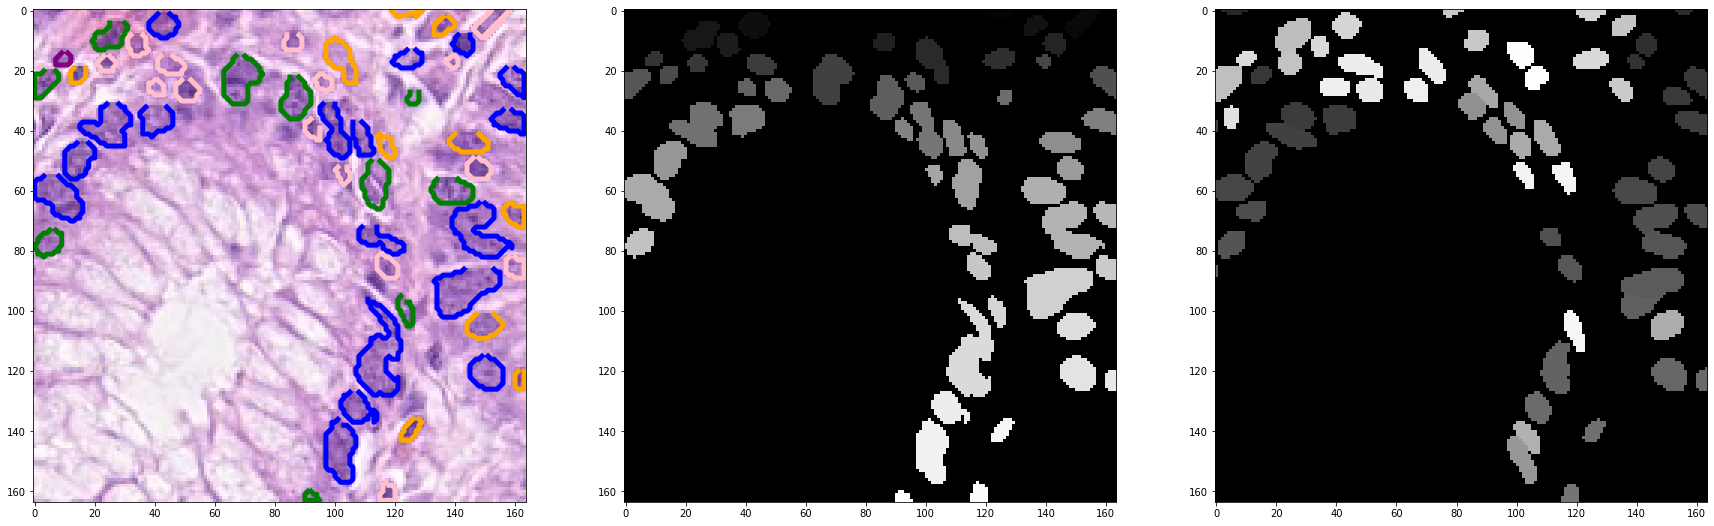

In [117]:
raw_image = val_input.squeeze().detach().cpu().numpy()
image = (CenterSpatialCropd(keys=["img"], roi_size=(164,164))({'img': val_input.squeeze()}))['img'].detach().cpu().numpy().transpose(1, 2, 0)
inst_map = val_output_[0][0].squeeze().detach().cpu().numpy()
inst_map_label = valid_data["label_inst"].squeeze().detach().cpu()
fig, ax = plt.subplots(1,3,figsize = (30,10))
ax[0].imshow(image, cmap='gray')
ax[1].imshow(inst_map, cmap='gray')
ax[2].imshow(inst_map_label, cmap='gray')
color_list = ['red', 'blue', 'green', 'purple', 'orange', 'pink']
for i, _contour in enumerate(contour_list):
    coords = [[], []]
    for i, coord in enumerate(_contour):
        coords[0].append(_contour[i][0])
        coords[1].append(_contour[i][1])
    color = color_list[type_list[i]-1]
    ax[0].plot(coords[0], coords[1], linewidth=5, color=color)